## Demod Notes 2.0

In this I will go through each step of the ```full_demod_process``` function and describe more cleanly what is happening. 

Doing explanations starting after the block where files are read in. 

In [1]:
# packages

import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import scipy

from scipy.signal import sawtooth, square, savgol_filter
import pandas as pd
import glob as gl
import os
import cmath

from scipy.signal import sawtooth, square,find_peaks, savgol_filter
from scipy import spatial
#import lambdafit as lf
from scipy.interpolate import CubicSpline,interp1d
import h5py

from tqdm import tqdm as tqdm_terminal
from tqdm.notebook import trange, tqdm_notebook
from scipy.signal.windows import hann

from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit

**Files used during demodulation:**
- Initial LO sweep 
- Targeted LO sweep 
- Frequency list
- Timestream data 

Loading in an example set of them here: 

In [2]:
# doing this to try out with LO sweeps, using 4250 init file 

# initial_lo_sweep_path = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/tone_initializations/fcenter_4250.0_20240216162215/lo_sweep_initial_fcenter_4250.0_20240216162224.npy'
# targeted_lo_sweep_path = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/tone_initializations/fcenter_4250.0_20240216162215/lo_sweep_targeted_2_fcenter_4250.0_20240216162651.npy'
# tone_freqs_path = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/tone_initializations/fcenter_4250.0_20240216162215/freq_list_lo_sweep_targeted_1_fcenter_4250.0_20240216162437.npy'
# ts_file = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/time_streams/ts_toneinit_fcenter_4250.0_20240216162215_t_20240216163432.hd5'



initial_lo_sweep_path = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/tone_initializations/fcenter_5250.0_20240216170412/lo_sweep_initial_fcenter_5250.0_20240216170434.npy'
targeted_lo_sweep_path = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/tone_initializations/fcenter_5250.0_20240216170412/lo_sweep_targeted_2_fcenter_5250.0_20240216171035.npy'
tone_freqs_path = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/tone_initializations/fcenter_5250.0_20240216170412/freq_list_lo_sweep_targeted_1_fcenter_5250.0_20240216170918.npy'
ts_file = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/time_streams/ts_toneinit_fcenter_5250.0_20240216170412_t_20240216173211.hd5'

Now, reading in the files. The frequency list and sweeps are in .npy files so can just use ```numpy``` but the .hd5 file needs to be read in with its package ```h5py```. This is defined as the ```read_data``` function. 

In the following cell, the function is defined, and an if-statement is defined for one of the main function's arguments about how many channels. Default is 'all' and because I'm doing these examples outside of the function environment I have to define it before. 

The ```read_data``` function takes the timestream data and pulls out the time, I and Q values and separates them into arrays, named ```ts_fr```, ```Is_fr```, ```Qs_fr``` 

In [3]:
# function

def read_data(filename,channels='all',start_channel=0,stop_channel=1000):
    if channels == 'all':
        file = h5py.File(filename, 'r')
        adc_i = np.array(file['time_ordered_data']['adc_i'])
        adc_i = np.delete(adc_i, slice(0,22), 0)
        adc_q = file['time_ordered_data']['adc_q']
        adc_q = np.delete(adc_q, slice(0,22), 0)
        t = np.array(file['time_ordered_data']['timestamp'])  
    elif channels == 'some':
        start_channel += 23 #eliminate the first 23 empty channels in hdf5 -> makes channel numbering match resonator numbering
        stop_channel += 23 + 1 #eliminate the first 23 empty channels in hdf5 -> makes channel numbering match resonator numbering; +1 forces python to include the stop_channel
        file = h5py.File(filename, 'r')
        adc_i = np.array(file['time_ordered_data']['adc_i'][start_channel:stop_channel]) 
        adc_q = np.array(file['time_ordered_data']['adc_q'][start_channel:stop_channel]) 
        t = np.array(file['time_ordered_data']['timestamp'])  
    
    return t, adc_i, adc_q

# actually load in data
channels='all'
start_channel=0
stop_channel=1000
initial_lo_sweep=np.load(initial_lo_sweep_path) #find initial lo sweep file
targeted_lo_sweep=np.load(targeted_lo_sweep_path) #find targeted sweep file
tone_freqs=np.load(tone_freqs_path) #find tone freqs
#print(tone_freqs)
if channels == 'some':
    tone_freqs = tone_freqs[start_channel + 23:stop_channel + 23 + 1]
    print(tone_freqs)
ts_fr,Is_fr,Qs_fr=read_data(ts_file,channels='all') 


In [4]:
# Maybe need to average the LO freq response first -- 

initial_lo_sweep[0,:].shape

(1000, 500)

In [ ]:
# chan_freqs_sub = []
# chan_s12_sub = []
# for i in range(len(initial_lo_sweep)): 
#     chan_tones = initial_lo_sweep[0,i,:]
#     chan_response = initial_lo_sweep[1,i,:]
    


In [ ]:
freq_tones_all = np.real(initial_lo_sweep[0])
len(freq_tones_all[0])

In [ ]:
np.average(freq_tones_all[0])

In [ ]:
for i in range(len(initial_lo_sweep)):
    

In [ ]:

initial_lo_sweep[0,:]

Then, the sample rate is defined. There are a couple different sample rates. This on, ```fs``` has to do with the RFSoC. 

The RFSoC processes data through a process described as "decimation via accumulator". First, there are data streaming in at 512 MHz (or Msps, mega samples per second). But if all of this data was coming in that quickly, computer would crash. SO: what it does is sets an "accumulation length", which in our case is $2^{19} - 1$ and takes that many data points, averages them together, and calls that one point, at a rate of 512 MHz. Your effective data rate can then be calculated as 

$$
\text{fs} = \frac{\text{base data rate}}{\text{accumulator number}} = \frac{512}{2^{19}-1} \approx 488.28 \text{ MHz}
$$

To rearrange the time data to fix a time-chunking issue, just being agnostic about time stamps and saying it's the length of the data divided evenly by the data rate (```ts_fr```).

In [ ]:
 #testing fixing the time breaks before the demod -- probably don't want to keep this but we'll see
fs=512e6/(2**20)    #this line is incredibly important; need to make sure we match the data rate at all times; add an if statement for faster data rate data
#fs=256e6/(2**19)
ts_fr = np.arange(Is_fr.shape[1])/fs

Then comes calibration of the **delay**, of which there are multiple sources. First is the step of the ```find_freqs_cable_delay_subtraction``` function, defined below. What it essentially does is going through the VNA scan which is the ```lo_sweep_initial```, looking for the first frequency it can find where there isn't a big dip (i.e. a resonator) by comparing the height of the $S_{21}$ response at each frequency, and picks a place to start the delay measurement region. Then it adds however many points you want (```n_freq```) after that and gives back your frequency range as two values ```f_start```, ```f_end```. The ```target = 0.98``` and ```n_freq = 10000``` values were what the team found worked best after playing with it for a while. 

*Still wondering: if there are only 1000 channels, why have 10000 as n_freq?*

In [ ]:
# name of function: finding the frequencies FOR the cable delay subtraction. 

def find_freqs_cable_delay_subtraction(initial_lo_sweep,target,n_freq):
   
    tests=initial_lo_sweep
    x=[]
    y=[]
    for i in range(tests.shape[1]): # shape is the number of tones (or channels?) 
        test_sweep=tests[:,i,:] # do loop for each channel
        x=np.append(x,test_sweep[0,:].real) # gets real values of frequency 
        y=np.append(y,20*np.log10(np.abs(test_sweep[1,:]))) # gets log power (response) for each frequency

    finite=np.asarray(np.where(np.isfinite(y) == True)) # gets an array of index values where there are no infinite or NaN y-values
    yfinite=y[finite].flatten() # get finite-index filtered y values (power)
    xfinite=x[finite].flatten() # get finite-index filtered x values (frequency)
    idmax=np.where(yfinite == np.max(yfinite)) # gets SINGLE index of the maximum response 
   
    # idgt=index array of the (x,y) values > target*ymax (id=index, gt=greater than)
    idgt=np.asarray(np.where(yfinite > (target*yfinite[idmax][0]))).flatten() # finds index of where the y value is greater than 0.98 times the max
    # got 0.98 value vy playing with things and tuning 
    # frequency range for cable delay
    f_start=xfinite[idgt[0]] # indexes that place in the frequency array for beginning freq
    f_end=xfinite[idgt[0]+n_freq] # indexes that place in frequency array + range wanted for ending freq

    #yfin_savgol = savgol_filter(yfinite, 500, 3)

    # usually commented out
    fig_test, ax_test = plt.subplots(1, figsize=(8,4))
    ax_test.plot(xfinite,yfinite, label='all values')
    ax_test.plot(x[idgt[0]:idgt[0]+n_freq], y[idgt[0]:idgt[0]+n_freq], label='special range')
    ax_test.set_xlabel('freq')
    ax_test.set_ylabel(r'$S_{21}$')
    ax_test.set_title('cable delay calculation range')
    ax_test.legend()
   
    return f_start, f_end, yfinite, y #yfinite, yfin_savgol, #ax_test

In [ ]:
s, e, yfin, jy = find_freqs_cable_delay_subtraction(initial_lo_sweep, 0.2, 10000)

In [ ]:
print(len(jy)/500)
print(s,e)

In [36]:
initial_lo_sweep.shape[1]

1000

In [4]:
chan_s12_sub = []
chan_tone_avg = []
chan_tone = []
chan_resp = []

for i in range(initial_lo_sweep.shape[1]): 

    lo_test = initial_lo_sweep[:,i,:]
    chan_tones = lo_test[0,:].real
    chan_response = lo_test[1,:]

    ch_tone_avg = np.average(chan_tones)
    s12_sub = chan_response - np.average(chan_response)

    chan_resp.append(chan_response)
    chan_s12_sub.append(s12_sub)
    chan_tone_avg.append(chan_tone_avg)
    chan_tone.append(chan_tones)

In [38]:
len(chan_s12_sub)

1000

In [ ]:
len(chan_tone_avg)

1000

In [10]:
len(chan_tone[0])

500

In [ ]:
for i in range(len(chan_tone)):
    plt.plot(chan_tone[i], np.abs(chan_s12_sub[i])**2, label=f'channel')

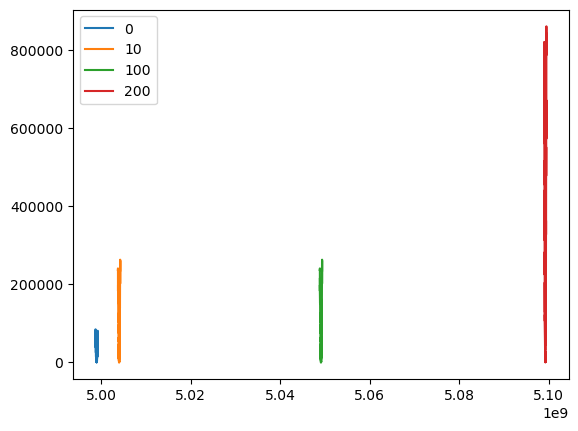

In [8]:

plt.plot(chan_tone[0], np.abs(chan_s12_sub[0])**2, label='0')
plt.plot(chan_tone[10], np.abs(chan_s12_sub[10])**2, label='10')
plt.plot(chan_tone[100], np.abs(chan_s12_sub[10])**2, label='100')
plt.plot(chan_tone[200], np.abs(chan_s12_sub[200])**2, label='200')

plt.legend()


In [9]:
len(chan_tone[0])

500

In [12]:
np.fft?

Type:        module
String form: <module 'numpy.fft' from '/Users/leayamashiro/anaconda3/lib/python3.11/site-packages/numpy/fft/__init__.py'>
File:        ~/anaconda3/lib/python3.11/site-packages/numpy/fft/__init__.py
Docstring:  
Discrete Fourier Transform (:mod:`numpy.fft`)

.. currentmodule:: numpy.fft

The SciPy module `scipy.fft` is a more comprehensive superset
of ``numpy.fft``, which includes only a basic set of routines.

Standard FFTs
-------------

.. autosummary::
   :toctree: generated/

   fft       Discrete Fourier transform.
   ifft      Inverse discrete Fourier transform.
   fft2      Discrete Fourier transform in two dimensions.
   ifft2     Inverse discrete Fourier transform in two dimensions.
   fftn      Discrete Fourier transform in N-dimensions.
   ifftn     Inverse discrete Fourier transform in N dimensions.

Real FFTs
---------

.. autosummary::
   :toctree: generated/

   rfft      Real discrete Fourier transform.
   irfft     Inverse real discrete Fourier tran

/Users/leayamashiro/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


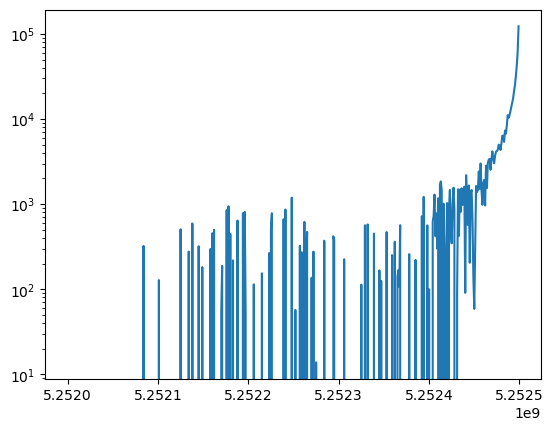

In [19]:


#plt.plot(chan_tone[500], fft((chan_s12_sub[500])))

plt.semilogy(chan_tone[500], (fft((chan_resp[500]))))

In [ ]:
plt.plot(chan_tone_avg, chan_s12_sub[0])

KeyboardInterrupt: 

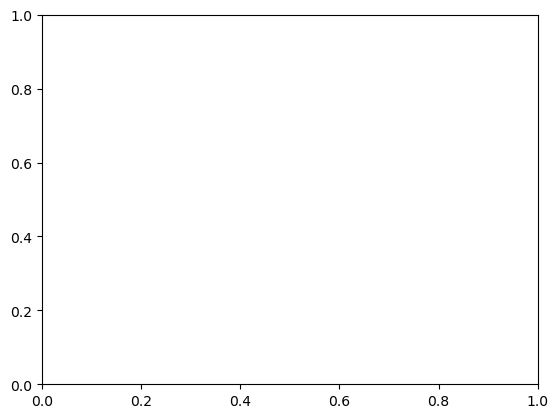

In [ ]:
plt.plot(chan_tone_avg, chan_s12_sub[0])

In [25]:
for i in range(len(initial_lo_sweep)): 

    lo_test = initial_lo_sweep[:,i,:]
    chan_tones = lo_test[0,:].real
    chan_response = lo_test[1,:]

In [27]:
chan_response.shape

(500,)

In [24]:
chan_s12_sub[0]

array([-1.43996e+02, -1.10996e+02, -1.34996e+02, -1.28996e+02,
       -7.44960e+01, -1.18996e+02, -1.33496e+02, -1.15996e+02,
       -1.23496e+02, -1.44996e+02, -1.03496e+02, -1.06996e+02,
       -9.09960e+01, -1.08496e+02, -1.08996e+02, -1.11496e+02,
       -1.36996e+02, -8.09960e+01, -1.02996e+02, -1.10496e+02,
       -1.33996e+02, -1.17496e+02, -1.12996e+02, -1.21996e+02,
       -9.29960e+01, -7.39960e+01, -1.02496e+02, -9.14960e+01,
       -1.20496e+02, -1.08996e+02, -9.39960e+01, -1.17996e+02,
       -1.06496e+02, -1.13496e+02, -1.06496e+02, -1.22496e+02,
       -1.18996e+02, -1.14996e+02, -7.84960e+01, -1.30496e+02,
       -1.16996e+02, -1.42496e+02, -1.32496e+02, -1.07996e+02,
       -1.05496e+02, -8.84960e+01, -9.99960e+01, -7.94960e+01,
       -1.16496e+02, -8.24960e+01, -8.89960e+01, -1.17996e+02,
       -9.99960e+01, -8.84960e+01, -1.17996e+02, -1.28496e+02,
       -1.27496e+02, -1.04996e+02, -7.94960e+01, -8.54960e+01,
       -1.29496e+02, -1.38996e+02, -8.79960e+01, -1.224

In [ ]:
chan_s12_sub.shape

In [ ]:
delay_region_start, delay_region_stop = find_freqs_cable_delay_subtraction(initial_lo_sweep,0.98,10000)

print('delay calculation tone region: ' + str((delay_region_start, delay_region_stop)))
print('absolute frequency width for tone region: ' + str((delay_region_stop-delay_region_start)))

Talk to Matt about edit to this function: 

In [ ]:

# okay now seeing that for fmin:fmax in the measure_delay_test_... function below, 
# need to have them as indices of the original 500-piece test_sweeps array
# use this index function integrated into the region function to get fmin and fmax

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
print(initial_lo_sweep[0,0,:])
# print(initial_lo_sweep[0,1,:])
# print(initial_lo_sweep[0,2,:])
# print(initial_lo_sweep[0,10,:])


In [ ]:
# using savitzky-golay filter to subtract out baseline
test_y_freq_values = 20*np.log10(np.abs(initial_lo_sweep[1,0,:]))
freq_vals = initial_lo_sweep[0,0,:]
baseline_filter = savgol_filter(test_y_freq_values, 500, 3)

In [ ]:
plt.plot(freq_vals, test_y_freq_values)
plt.plot(freq_vals, baseline_filter)
#plt.plot(freq_vals, np.abs(test_y_freq_values - baseline_filter)**2)

In [ ]:
tests=initial_lo_sweep
x=[]
y=[]
for i in range(tests.shape[1]): # shape is the number of tones (or channels?) 
    test_sweep=tests[:,i,:] # do loop for each channel
    x=np.append(x,test_sweep[0,:].real) # gets real values of frequency 
    y=np.append(y,20*np.log10(np.abs(test_sweep[1,:]))) # gets log power (response) for each frequency

finite=np.asarray(np.where(np.isfinite(y) == True)) # gets an array of index values where there are no infinite or NaN y-values
yfinite=y[finite].flatten() # get finite-index filtered y values (power)
xfinite=x[finite].flatten() # get finite-index filtered x values (frequency)
print(len(yfinite))

In [20]:
# name of function: finding the frequencies FOR the cable delay subtraction. 
# problem: only outputs exact frequency tone (f_start, f_stop), not the index of the start and stop 
# use find_nearest_idx to get it working? 

def find_freqs_cable_delay_subtraction_copy(initial_lo_sweep,target,n_freq):
   
    tests=initial_lo_sweep
    x=[]
    y=[]
    for i in range(tests.shape[1]): # shape is the number of tones (or channels?) 
        test_sweep=tests[:,i,:] # do loop for each channel
        x=np.append(x,test_sweep[0,:].real) # gets real values of frequency 
        y=np.append(y,20*np.log10(np.abs(test_sweep[1,:]))) # gets log power (response) for each frequency

    finite=np.asarray(np.where(np.isfinite(y) == True)) # gets an array of index values where there are no infinite or NaN y-values
    yfinite=y[finite].flatten() # get finite-index filtered y values (power)
    xfinite=x[finite].flatten() # get finite-index filtered x values (frequency)
    print(len(yfinite))
    yfinite_filtered = savgol_filter(yfinite, len(yfinite), 3)
    
    
    
    idmax=np.where(yfinite == np.max(yfinite)) # gets SINGLE index of the maximum response
    #print(len(yfinite), len(xfinite))

    # idgt=index array of the (x,y) values > target*ymax (id=index, gt=greater than)
    idgt=np.asarray(np.where(yfinite > (target*yfinite[idmax][0]))).flatten() # finds index of where the y value is greater than 0.98 times the max
    # got 0.98 value vy playing with things and tuning 
    # frequency range for cable delay
    f_start=xfinite[idgt[0]] # indexes that place in the frequency array for beginning freq
    f_end=xfinite[idgt[0]+n_freq] # indexes that place in frequency array + range wanted for ending freq


    
    f_start_idx = find_nearest_idx(tests[0,0,:], f_start)
    f_stop_idx = find_nearest_idx(tests[0,0,:], f_end)

    # usually commented out
    fig_test, ax_test = plt.subplots(1, figsize=(8,4))
    ax_test.plot(xfinite,yfinite, label='all values')
    ax_test.plot(x[idgt[0]:idgt[0]+n_freq], y[idgt[0]:idgt[0]+n_freq], label='special range')
    ax_test.set_xlabel('freq')
    ax_test.set_ylabel(r'$S_{21}$')
    ax_test.set_title('cable delay calculation range')
    ax_test.legend()


   
    return f_start, f_end, f_start_idx, f_stop_idx #ax_test

In [21]:
%matplotlib qt
delay_region_start, delay_region_stop = find_freqs_cable_delay_subtraction_copy(initial_lo_sweep,0.2,10000)
#delay_region_start, delay_region_stop, delreg_idxstart, delreg_idxstop = find_freqs_cable_delay_subtraction_copy(initial_lo_sweep,0.5,10000)
print('delay calculation tone region: ' + str((delay_region_start, delay_region_stop)))
#print('delay calculation tone region indices: ' + str((delreg_idxstart, delreg_idxstop)))
print('absolute frequency width for tone region: ' + str((delay_region_stop-delay_region_start)))

/var/folders/ky/hnfmqvvd74x03rjxm1q6hf580000gn/T/ipykernel_72101/292984545.py:13: RuntimeWarning: divide by zero encountered in log10
  y=np.append(y,20*np.log10(np.abs(test_sweep[1,:]))) # gets log power (response) for each frequency


495000


Now that there's a range to calculate the delay on, the delay is calculated with ```measure_delay_test_given_freq```.

In [ ]:
# test_sweeps object for this function is usually the initial_lo_sweep data 
# fmin, fmax define the frequency range for measuring the delay, for this point in the 
# full_demod_process function, the inputs are delay_region_start,delay_region_stop, outputs from the previous function 
# # if i give you a frequency span, measure the delay 


# okay so, this actually doesn't seem like it's operating on that frequency region, because in the np.polyfit 
# it is acting on all values of test_sweep, not the frequency range... making copy of function in cell below: 

def measure_delay_test_given_freq(test_sweeps,fmin,fmax,plot=False):
    """
    Manually enter frequency region for cable delay measurement.
    First 100 points currently used because of system stability issue. Might remove in the future if it gets better.
    """
    delays=[] # empty delay list
    for i in range(test_sweeps.shape[1]): # length = number of channels 
        test_sweep=test_sweeps[:,i,:] # takes each channel in sweep as i, then each item in test_sweep is two values? 
        freq_start=np.min(test_sweep[0,:].real) # freq start with range 
        freq_stop=np.max(test_sweep[0,:].real) # freq stop with range
        if freq_start>fmin and freq_stop<fmax: # makes sure it's within bounds of the range calculated before 
            # polyfit takes x, y values
            # x = first 100 frequency points, takes real-valued frequency from first block
            # y = phase value using the complex value in second block
            # fits polynomial, extracts coefficient as m
            m,b = np.polyfit(test_sweep[0,:100].real, [cmath.phase(x) for x in test_sweep[1,:100]], 1)
            # slope m corresponds to change in phase with respect to frequency
            # tau takes the phase info and converts to a time delay
            tau=-m/(2*np.pi)
            delays.append(tau)
    delays=np.array(delays)
    delays_sel=delays[np.where(delays>0)] # filters for zero delays
    if plot==True: # plot delay distribution
        #plt.figure(figsize=(11,8))
        plt.figure(figsize=(5,4))
        plt.hist(delays_sel*1e9,bins=np.linspace(0,100,50))
        plt.xlabel('Cable Delay (ns)')
        plt.ylabel('Number of Segments')
    return delays_sel # returns the selected delay array

In [ ]:



def measure_delay_test_given_freq_COPY(test_sweeps,fmin,fmax,plot=False):
    """
    Manually enter frequency region for cable delay measurement.
    First 100 points currently used because of system stability issue. Might remove in the future if it gets better.
    """
    delays=[] # empty delay list
    for i in range(test_sweeps.shape[1]): # length = number of channels 
        test_sweep=test_sweeps[:,i,:] # takes each channel in sweep as i, then each item in test_sweep is two values?
        print(test_sweep.shape) 
        freq_start=np.min(test_sweep[0,:].real) # freq start with range 
        freq_stop=np.max(test_sweep[0,:].real) # freq stop with range
        if freq_start>fmin and freq_stop<fmax: # makes sure it's within bounds of the range calculated before 
            # polyfit takes x, y values
            # x = first 100 frequency points, takes real-valued frequency from first block
            # y = phase value using the complex value in second block
            # fits polynomial, extracts coefficient as m
            #m,b = np.polyfit(test_sweep[0,fmin:fmax].real, [cmath.phase(x) for x in test_sweep[1,fmin:fmax]], 1)
            m,b = np.polyfit(test_sweep[0,:].real, [cmath.phase(x) for x in test_sweep[1,:]], 1)
            # slope m corresponds to change in phase with respect to frequency
            # tau takes the phase info and converts to a time delay
            tau=-m/(2*np.pi)
            delays.append(tau)
    delays=np.array(delays)
    delays_sel=delays[np.where(delays>0)] # filters for zero delays
    if plot==True: # plot delay distribution
        #plt.figure(figsize=(11,8))
        plt.figure(figsize=(5,4))
        plt.hist(delays_sel*1e9,bins=np.linspace(0,100,50))
        plt.xlabel('Cable Delay (ns)')
        plt.ylabel('Number of Segments')
    return delays_sel # returns the selected delay array

This function essentially takes in some frequency range, and gives a time delay. First, it starts a loop over the number of channels (same as before, using the initial LO sweep data), making sure that the range chosen to calculate the delay is inside the general frequency range of the data (confirm visually above). Then, it uses ```np.polyfit(x, y, deg)``` as a first-degree polynomial, with x equal to the frequency (```test_sweep[0,:100].real```), y equal to the phase angle of the complex response (```[cmath.phase(x) for x in test_sweep[1,:100]```). So equation is: 
$$
\theta= m f + b
$$

We don't care about b, only m. Because it gives a value for the slope of the phase across this range of frequency. As in, 
$$
m \propto \frac{\theta}{f}
$$

So for each channel, we look at the phase of the complex response we get out during the sweep for all of the LO steps (although here is only 100). This phase slope $m$ (a least-squares average) is then put into the equation for time delay in the function, where
$$ 
\tau = -\frac{m}{2\pi} = -\frac{\frac{\theta}{f}}{2\pi} = -\frac{\theta}{2\pi f}
$$

and a list of these Taus are appended to the list ```delays```. Effectively, it averages the phase of the complex response data for each channel over the course of the sweep. NOTE the intuition of the derivaiton: 
$$
\text{Signal: } V(t) = e^{2\pi i f t}
$$

$$
\begin{aligned} \text{Delayed Signal: } V(t) &= e^{i2\pi i f(t - \tau)} \\ 
&= (e^{i2\pi i ft})(e^{-i2\pi  f\tau}) \\ 
\Delta\phi &= - 2\pi f \tau \\
\tau &= -\frac{\Delta \phi}{2\pi f} \\ 
&= -\frac{\theta}{2\pi f}
\end{aligned}
$$

SO -- the phase being calculated in the ```cmath.phase(x)``` line is the *change* in phase, or just the actual *angle* between the real and imaginary components of the signal. This is because the whole thing is being represented in Euler's form where $V = e^{i\theta}$. So the phase difference is literally the difference in the two angles equal to $(2\pi ft)$ and $(-2\pi f\tau)$ !! 

The code currently has a delay inspection tool where it selects all delays that were calculated as nonzero and then (if plot==True) plots them as a histogram to see the nanosecond delay distribution. 

But I was confused about what the phase information might actually look like, so I tried to inspect a few channels (in cell below).

In [ ]:
test_sweeps = initial_lo_sweep
fmin, fmax = delay_region_start, delay_region_stop

delays=[] # empty delay list
test_swept=[]
for i in range(test_sweeps.shape[1]): # length = number of channels 
    test_sweep=test_sweeps[:,i,:] # test sweep becomes object with each channel, holding the 500 frequencies in test_sweeps[0] and 500 S_21 in test_sweeps[1]
    freq_start=np.min(test_sweep[0,:].real) # freq start with range 
    freq_stop=np.max(test_sweep[0,:].real) # freq stop with range
    test_swept.append(test_sweep)
    if freq_start>fmin and freq_stop<fmax: # makes sure it's within bounds of the range calculated before 
        # polyfit takes x, y values
        # x = first 100 frequency points, takes real-valued frequency from first block
        # y = phase value using the complex value in second block
        # fits polynomial, extracts coefficient as m
        m,b = np.polyfit(test_sweep[0,:].real, [cmath.phase(x) for x in test_sweep[1,:]], 1)
        # slope m corresponds to change in phase with ***respect to frequency*** 
        # m is not tau, m is 
        # tau takes the phase info and converts to a time delay
        tau=-m/(2*np.pi)
        delays.append(tau)


fig, ax = plt.subplots(15, figsize = (5,25))
for i in range(len(test_swept[500:515])):
    single_channel = test_swept[500+i]
    phases=[]
    for x in single_channel[1,:]:
        phase = cmath.phase(x)
        phases.append(phase)

    ax[i].scatter(single_channel[0,:].real, phases, marker='.')
    ax[i].set_title(f'Channel {500+i} Phases')
    ax[i].set_xlabel('frequency (tones)')
    ax[i].set_ylabel('phase ($\Theta$)')
plt.tight_layout()



Actually calculating the delays: 

In [ ]:
#measure cable delay
delays = measure_delay_test_given_freq(initial_lo_sweep,delay_region_start,delay_region_stop,plot=True) 
# delay_region_start,delay_region_stop are outputs from figuring out the frequency range from previous function 

print(f'delay: {np.median(delays)}')

So this is about 60 ns. Yu's paper had average cable delay on order of 100 ns...

In [ ]:
# WITH NEW VERSION

#measure cable delay
delays = measure_delay_test_given_freq_COPY(initial_lo_sweep,delay_region_start,delay_region_stop,plot=True) 
# delay_region_start,delay_region_stop are outputs from figuring out the frequency range from previous function 

print(f'delay: {np.median(delays)}')

delay with np.max in the function that finds the region for delay calculation:
delay: 6.430838030860101e-08

Now actually fixing the delays: 

This operation happens on a new set of data, which is the "targeted sweep," and is the sweep data after the script has fixed the location of the resonators and is only sending tones out to a set number of resonators. 

Function ```remove_delay``` takes the targeted sweep data, makes a copy, iterates through each channel, creates a delay factor term where $\tau$ is the median of the delays found in the previous function, and $f$ is all of the 500 frequency tones from the first data block. This factor term is equivalent to
$$
\text{delay factor} =\large e^{2 \pi i \tau f}
$$

in the code, the $i$ has to be written as ```j``` (also, in reference to the equation above, since the delay term has a negative exponent initially, the delay *factor* term has a positive exponent (inverse to correct). 

The delay factor itself is 500-item array that is multiplied item-wise to all 500 LO steps of the complex data, for each of the reduced (<1000) number of channels in the targeted sweep data, effectively removing the delay.

In [ ]:
# REMOVE DELAY FUNCTION WITH DELAY FACTOR EXAMPLE: 

def remove_delay_factor_example(target_sweeps,delay,channels='all',start_channel=0,stop_channel=1000):
    target_sweeps_rm=target_sweeps.copy()
    
    # defining loop ranges
    if channels == 'all':
        loop_range = range(target_sweeps.shape[1]) 
    elif channels == 'some':
        loop_range = range(stop_channel-start_channel)
    
    # removing the delays
    for i in loop_range:
        target_sweep=target_sweeps[:,i,:] # going for each channel where there's a tone
        freqs=target_sweep[0,:] # first block, full 500 MHz bandwidth 
        delay_fac=np.exp(1j*delay*2*np.pi*freqs) # for each of the 231 channels (i), delay factor uses 500 LO steps as "freqs" 
        target_sweeps_rm[1,i,:]=target_sweeps[1,i,:]*delay_fac # for each channel of the second block, multiply array by the delay factor (element wise)
            
    return target_sweeps_rm, delay_fac 

In [ ]:
def remove_delay(target_sweeps,delay,channels='all',start_channel=0,stop_channel=1000):
    target_sweeps_rm=target_sweeps.copy()
    
    # defining loop ranges
    if channels == 'all':
        loop_range = range(target_sweeps.shape[1]) 
    elif channels == 'some':
        loop_range = range(stop_channel-start_channel)
    
    # removing the delays
    for i in loop_range:
        target_sweep=target_sweeps[:,i,:] # going for each channel where there's a tone
        freqs=target_sweep[0,:] # first block, full 500 MHz bandwidth 
        delay_fac=np.exp(1j*delay*2*np.pi*freqs) # for each of the 231 channels (i), delay factor uses 500 LO steps as "freqs" 
        target_sweeps_rm[1,i,:]=target_sweeps[1,i,:]*delay_fac # for each channel of the second block, multiply array by the delay factor (element wise)
            
    return target_sweeps_rm

Actually applying the function: 

In [ ]:
targeted_lo_sweep_rm, delay_factor_example =remove_delay_factor_example(targeted_lo_sweep,
                                    np.median(delays),
                                    channels=channels,
                                    start_channel=start_channel,
                                    stop_channel=stop_channel)

Checking out "delay factor" array: 

In [ ]:
print('Delay factor dimensions: ' + str(delay_factor_example.shape))
print('Delay Factor Median = ' + str(np.median(delay_factor_example)))
print('Delay Factor Array:')
print(delay_factor_example)

Checking out difference between LO Sweep data before and after delay removal: 

In [ ]:


fig, ax = plt.subplots(3, figsize = (7, 12))
# plt.grid(True)
# plt.legend()

ax[0].plot(np.arange(0, len(targeted_lo_sweep[1]), 1), (targeted_lo_sweep[1,0,0:231].real + 1j*targeted_lo_sweep[1,0,0:231].imag), 
            label= r'$S_{21}$ delayed')
ax[0].plot(np.arange(0, len(targeted_lo_sweep_rm[1]), 1), (targeted_lo_sweep_rm[1,0,0:231].real + 1j*targeted_lo_sweep_rm[1,0,0:231].imag), 
            label=r'$S_{21}$ fixed')
ax[0].plot(np.arange(0, len(targeted_lo_sweep_rm[1]), 1), np.abs(((targeted_lo_sweep_rm[1,0,0:231].real + 1j*targeted_lo_sweep_rm[1,0,0:231].imag) 
                                                            - (targeted_lo_sweep[1,0,0:231].real + 1j*targeted_lo_sweep[1,0,0:231].imag))), 
                                                            label = r'abs($\Delta S_{12}$)', marker='.')
ax[0].set_title('Target Sweep Delay Removal Channel 0')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(np.arange(0, len(targeted_lo_sweep[1]), 1), (targeted_lo_sweep[1,100,0:231].real + 1j*targeted_lo_sweep[1,100,0:231].imag), 
            label=r'$S_{21}$ delayed')
ax[1].plot(np.arange(0, len(targeted_lo_sweep_rm[1]), 1), (targeted_lo_sweep_rm[1,100,0:231].real + 1j*targeted_lo_sweep_rm[1,0,0:231].imag), 
            label=r'$S_{21}$ fixed')
ax[1].plot(np.arange(0, len(targeted_lo_sweep_rm[1]), 1), np.abs(((targeted_lo_sweep_rm[1,100,0:231].real + 1j*targeted_lo_sweep_rm[1,100,0:231].imag) 
                                                            - (targeted_lo_sweep[1,100,0:231].real + 1j*targeted_lo_sweep[1,100,0:231].imag))), 
                                                            label = r'abs($\Delta S_{12}$)', marker='.')
ax[1].set_title('Target Sweep Delay Removal Channel 100')
ax[1].grid(True)
ax[1].legend()


ax[2].plot(np.arange(0, len(targeted_lo_sweep[1]), 1), (targeted_lo_sweep[1,200,0:231].real + 1j*targeted_lo_sweep[1,200,0:231].imag), 
            label=r'$S_{21}$ delayed')
ax[2].plot(np.arange(0, len(targeted_lo_sweep_rm[1]), 1), (targeted_lo_sweep_rm[1,200,0:231].real + 1j*targeted_lo_sweep_rm[1,200,0:231].imag), 
            label=r'$S_{21}$ fixed')
ax[2].plot(np.arange(0, len(targeted_lo_sweep_rm[1]), 1), np.abs(((targeted_lo_sweep_rm[1,200,0:231].real + 1j*targeted_lo_sweep_rm[1,200,0:231].imag) 
                                                            - (targeted_lo_sweep[1,200,0:231].real + 1j*targeted_lo_sweep[1,200,0:231].imag))), 
                                                            label = r'abs($\Delta S_{12}$)', marker='.')
ax[2].set_title('Target Sweep Delay Removal Channel 200')
ax[2].grid(True)
ax[2].legend()


plt.setp(ax, xlabel='channel #', ylabel=r'$S_{21}$')
plt.tight_layout()


Now the function needs to remove the delay from the timestream data as well, using ```remove_delay_timestream```. 

The function just operates on each of the channels, contained by the ```f0s``` variable input in the parameters, which should be an array taken from the frequency list (```tone_freqs```) loaded in the beginning. This is based on the same equation as before, and the delay factor is calculated in the same way, except for that when removing it previously, each of the channels had to have a 500-item correction. In this case, each channel has just one tone (not 500), and one has to correct all of the items in the *time series data*, broken up into t, I, Q already. The arrays of ```I + jQ``` is input as "stream", and the same median delay (tau) value is used. 

It's a correction being applied in the time domain rather than the frequency domain, but it is the same general complex wave formula, $V(f,t)$ so the multiplied delay factor is the same: 

$$
\text{Signal: } V(t) = e^{2\pi i f t}
$$

$$
\begin{aligned} \text{Delayed Signal: } V_{del}(t) &= e^{2\pi i f(t - \tau)} \\ 
\text {Corrected Signal: } V_{fix}(t) &= (e^{2\pi i f(t - \tau)})(e^{2\pi i f \tau}) \\
&= e^{2\pi i f(t - \tau) + 2\pi i f \tau} \\
&= e^{2\pi i f (t - \tau + \tau)} \\
&= e^{2\pi i f t} 
\end{aligned}
$$

And the time delay is removed from the signal! 

In [ ]:
# removing delay timestream function

def remove_delay_timestream(stream,f0s,delay):
    stream_rm=np.zeros((f0s.shape[0],stream.shape[1]),dtype = 'complex_') # make zeros array with shape of (tone_freqs, shape of second timestream data block)
    for i in range(f0s.shape[0]):
        #print(delay)
        #print(f0s)
        delay_fac=np.exp(1j*2*np.pi*f0s[i]*delay)
        #print(delay_fac)
        stream_rm[i,:]=stream[i]*delay_fac
    return stream_rm

# need to know frequency of tone you're dealing with for each i 
# each tone is modulating data at each frequency 

Remove time delay from timestream data: 

In [ ]:
IQ_stream_rm=remove_delay_timestream(Is_fr+1j*Qs_fr,tone_freqs,np.median(delays))

In [ ]:
IQ_stream_rm.shape

In [ ]:
# image from Yu paper for personal use (put in markdown cell): 
    # ![Screenshot 2025-02-13 at 4.10.04 PM.png](<attachment:Screenshot 2025-02-13 at 4.10.04 PM.png>)

(That all had to do with cable delay. Now we calibrate the intrinsic delay.)

Now actually calibrating the signal!! 

Copying from SMuRF paper for reference: 

From SMuRF: " For µmux systems, we are typically interested in modulation of the resonance frequency due to incoming power on
the detector. We thus seek to transform our complex digital data to an estimate of resonator frequency shifts. We transform shifts of the resonance frequency into shifts entirely in
the phase (Q) direction of the resonator response via a rotation
and scaling of the resonator’s complex response, allowing us
to ignore changes in the amplitude direction (I). Equivalently,
we rotate the resonator circle in the complex plane such that it
is oriented as given in Figure 2, and approximate small movements near the resonance frequency as occurring along a single axis.."

The resonator has a response in the complex plane corresponding to the real and imaginary components of the $S_{21}$ response. This response may be rotated and scaled by a complex number $\eta$ such that for small changes in resonance frequency, the change in $S_{21}$ is entirely in a single quadrature. 

For $(I_{\pm}, Q_{\pm})$, complex transmission measured at some frequency offset $\pm \Delta f$ from the resonance frequency, estimate $\eta$: 
$$
\eta  = \frac{2\Delta f}{(I_+ - I_-) + i(Q_+ - Q_-)}
$$

Denominator gives angle in complex plane needed to rotate resonance circle. Magnitude set by sharpness of the resonance. $\eta$ has effect of rotating and scaling circle such that the real and complex axes have physically meaningful units... with $S^{\text{min}}_{21}$ rotated to be parallel to the imaginary axis. 


With this calibration, frequency shift can be estimated as 
$$
\Delta f \sim \hat \Delta f = \text{Im}[S_{21}(\Delta f) \times \eta]
$$

(Hat = estimate.) $S_{21}(\Delta f)$ IS the complex transmission at the shifted resonance frequency. This is the same as projecting the rotated and scaled $S_{21}$ response at the probe tone frequency onto a single axis.


### **Note (after meeting with Matt 02/19/25):** 
#### Those equations from the Yu don't actually apply because Ali's detectors don't have the same tone-tracking mechanism that allowed SMuRF to do this (Matt tried this method, shown by the ```find_eta``` function somewhere in the demod scripts, but it didn't work). These equations do show the basis for what we are trying to achieve at this step of the demodulation process, which is finding the frequency shift by rotating the resonator circle into a corrected location such that we can see a small **$\delta f$** as a phase difference projected onto the imaginary axis (in a [Re, Im] coordinate plane), but we use a different method, shown below with the matrix transformation... 

In [ ]:
# second image from SMuRF paper for personal use (put into markdown cell):
    # ![Screenshot 2025-02-13 at 4.34.13 PM.png](<attachment:Screenshot 2025-02-13 at 4.34.13 PM.png>) 

In [ ]:
def calculate_M(target_sweep_one):
    I=target_sweep_one[1,:].real # real components of S21 sweep data
    Q=target_sweep_one[1,:].imag # imaginary components of S21 sweep data
    z=I**2+Q**2 # squared magnitude of complex value for each data point
    
    M=np.zeros((4,4)) # 4x4 matrix to populate 

    # matrix encodes system of equations related to resonator geometry
    # purpose is to capture various sums involving I and Q
    # and their relationships... 

    M[0,0]=np.sum(z**2.) # sum of squared mag, weighed by squared mag. Essentially "size" of data points and their complex distribution
    M[1,1]=np.sum(I**2.) # sum of squares of I values, capture relationship of in-phase component to overall system
    M[2,2]=np.sum(Q**2.) # sum of squares of Q, relationship of quadrature component to overall system
    M[3,3]=I.shape[0] # setting last diagonal term as number of points in data = normalization factor

    M[0,1]=np.sum(I*z) # (THESE TWO) coupling between in-phase component I and squared mag of data (represent 
    M[1,0]=np.sum(I*z) # relationship of in-phase component w/ magnitude)
    M[0,2]=np.sum(Q*z) # (THESE TWO) coupling between quadrature component and squared magnitude
    M[2,0]=np.sum(Q*z) # how the phase information interacts with the magnitude 

    M[0,3]=np.sum(z) # (THESE TWO) terms introduce sum over all data points' squared magnitudes into system
    M[3,0]=np.sum(z)
    M[1,2]=np.sum(I*Q) # (THESE TWO) coupling between in-phase and quadrature components 
    M[2,1]=np.sum(I*Q) # and gets phase relationship between them

    M[1,3]=np.sum(I) # (THESE TWO) sum of in-phase components
    M[3,1]=np.sum(I) 
    M[2,3]=np.sum(Q) # (THESE TWO) sum of quadrature components 
    M[3,2]=np.sum(Q)

    return M

(Done copying Cyndia Yu) This was all to give context for what is happening in the next few steps of calibration. 

First need to measure the circle, which uses a function ```calculate_M``` to calculate on the matrix $M$ calculated in the following cell, dependent on $I$, $Q$, and $z = I^2 + Q^2$. 
$$
M = 
\begin{bmatrix}
\sum z^2 & \sum Iz & \sum Qz & \sum z \\ %(0,0) - (0,3)
\sum Iz & \sum I^2 & \sum IQ & \sum I \\ %(1,0) - (1,3)
\sum Qz & \sum IQ & \sum Q^2 & \sum Q \\ %(2,0) - (2,3)
\sum z & \sum I & \sum Q & n_{\text{channels}} %(3,0) - (3,3)
\end{bmatrix}
$$

But why set up this way?? 

(CONFIRM:) Once matrix M is formed, it can be solved in the next step as an eigenvalue problem. Matrix formulation is way of fitting circle to resonance data by minimizing the differences between expected circle and actual resonance points in the complex (I, Q) plane. 

Also, I and Q interact in symmetric ways, so the matrix to be solved needs to reflect that symmetry, so certain sums will appear more than once. I and Q are both part of the same vector, so the fitting problem looks for teh best circle that describes how these components are related, so the sums need to appear multiple times. 

This is because in order to get the phase information about the resonator, we need to get circle dimensions, and to do that, we solve a generalized eigenvalue problem. Recall, with standard eigenvalue problem, we have
$$
M \cdot v = \lambda \cdot v 
$$
such that the characteristic equation is
$$
(A - \lambda I) = 0
$$
where $I$ is the identity matrix used to solve a system of linear equations for $v$, the nonzero *eigenvector* and $\lambda$ the eigenvalues. There are nontrivial solutions of the eigenvector when $\text{det}(A - \lambda I) = 0$. (Solve this equation for lambda, get eigenvalues, substitute back in for eigenvectors.) 

But in the ```measure_circle``` function we have ```scipy.linalg.eig(M,B)```, which itself is solving a *generalized* eigenvalue problem. Recall: 
$$
M \cdot v = \lambda \cdot B \cdot v 
$$
where M and B are both square matrices. 

Instead of solving for one matrix, you are solving for how $M$ and $B$ work together to form a system of linear equations. Need to clarify: but it seems like the $B$ matrix is used here to capture the geometry of the resonator or the fitting model constraints: 

$$
B = \begin{bmatrix}
0 & 0 & 0 & -2 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
-2 & 0 & 0 & 0
\end{bmatrix}
$$

Why might $B$ be set up this way? The second and third diagonal elements are 1, which probably corresponds to constraints on the real and imaginary components of the resonator data ($I, Q$)... suggests these values should contribute linearly to center of the circle. Also determines how the center coordinates influences the fitting process. The 0s and 2s cause a connection between first and last variables in the system, and encode the relationship between the squared I and Q terms. Negative sign suggests they are constraining fit in certain direction (controlling phase or distance between center and resonance freq affects geometry of circle. The off-diagonal -2s seem to impact geometrical fitting process where they are linearly stretching or pulling in the eigenvector directions.)

**Clarify:** where did the $M$ matrix come from in terms of structure?? Where did $B$ matrix come from ?? 

Here, the function will be able to solve this system of equations, and give back eigenvalues and eigenvectors. 
- **Eigenvalues** will give the scaling factors that describe the system's behavior (vague, clarify). 
- **Eigenvectors** will give the direction in the complex plane in *which* the system behaves scaled by that eigenvalue (?) 

The second eigenvector ```V[:,IX[1]]``` gives the information for the center and radius of the resonator circle. 

On the **radius**: 

Based on the code, it is calculated as 
$$
R = \sqrt{x_{center}^2 + y_{center}^2 + \frac{V[3]}{V[0]}}
$$

The third term under the square root seems to account or compensate for any distortion or stretch imposed by the eigenvalue solution, ensuring radius reflects the true radius of the circle. 

Then, after calculating these properties, the ```measure_circle``` function gives back the (x,y) position of the resonator circle in the complex plane, the radius of the circle, and the phase difference of the actual data's phase and the circle center. (???)

**need clarification on $\phi_0$ here.**

In [ ]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
# This function calculates the center, radius, and initial phase of the resonator circle 
# using the matrix M and solving an eigenvalue problem

def measure_circle(target_sweep,f0):
    """ Finds the resonator circle's center

    Args:
        target_sweep: target S21 sweep around one resonator, col0 is freq, col1 is complex S21
        tau: cable delay in s

    Returns:
        center and radius on the complex plane, and initial phase
    """
    M=calculate_M(target_sweep) # employs the matrix function on the target sweep I, Q data 
    B = np.array([[0,0,0,-2],[0,1,0,0],[0,0,1,0],[-2,0,0,0]]) # reference matrix for the eigenvalue problem. Origin? 
    VX=scipy.linalg.eig(M, B) # solves eigenvalue problem using the reference matrix B, outputs (eigenvalues, eigenvectors)
    X=VX[0] # eigenvalues
    V=VX[1] # eigenvectors
    C=np.sort(X,0) 
    IX=np.argsort(X,0) # sort eigenvalues along index (IX = indexed X)
    Values = V[:,IX[1]] # extract eigenvector corresponding to 2nd eigenvalue (representing the resonator circle’s parameters)
    xc = -Values[1]/(2*Values[0]) # circle center's x-coordinate 
    yc = -Values[2]/(2*Values[0]) # circle center's y-coordinate
    R = (xc**2+yc**2-Values[3]/Values[0])**0.5 # radius of the circle (all based on resonator geometry)
    ind=find_nearest_idx(target_sweep[0,:], f0) # finds index nearest to the frequency in data closest to f0
    phi_0=cmath.phase(target_sweep[1,ind]-xc-1j*yc) # calculates phase at that index (phase diff between the complex value and the circle’s center.)
    return np.array([xc+1j*yc,R,phi_0]) # gives circle info in complex plane (x + iy, R, and phi_0)

Following function just employs previous function at scale: 

In [ ]:
def measure_circle_allch(target_sweeps,f0s,channels='all',start_channel=0,stop_channel=1000):
    cals=[]
    
    # set frequency range for LO sweep calibration
    if channels == 'all':
        loop_range = range(target_sweeps.shape[1])
    elif channels == 'some':
        loop_range = range(stop_channel - start_channel)
    
    # loop through, apply measure_circle function
    for i in loop_range:
        sweep=target_sweeps[:,i,:]
        cal=measure_circle(sweep,f0s[i])
        cals.append(cal)
    # save calibration (circle info) in stacked vector
    cals=np.vstack(cals)

    print(f'shape_cals: {cals.shape}')
    return cals  

Actually calibrating:  

In [ ]:
calibration=measure_circle_allch(targeted_lo_sweep_rm,
                                     tone_freqs,
                                     channels=channels,
                                     start_channel=start_channel,
                                     stop_channel=stop_channel) #finds circle center and initial phase for every channel

print(calibration[0]) 

In [ ]:
calculate_M(targeted_lo_sweep)

In [ ]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Next part of function: 

Extracting phase information from the calibration (circle info) and the timestream. Relies on ```get_phase``` function. 

In [ ]:
def get_phase(timestreams,calibration):
    """ Finds the resonator circle's center
    
    Args:
        timestream : timestream data in I and Q for all resonators
        phi_init: initial phase at f0
        calibration: (rows = n_channels) col0 center, col1 radius, col2 initial phase

    Returns:
        phase of timestream in radian
    """
    phases=[]
    for i in range(calibration.shape[0]): # iterates through stacked circle data, each i is channel
        timestream=timestreams[i] # gets (I + jQ) timestream data for channel i
        center = calibration[i,0] # gets x, y circle center location in complex plane (x + jy)
        phi_init=calibration[i,2] # gets initial phase from circle data
        timestream_origin=timestream-center # positioning timestream data at origin of circle???? 
        timestream_rot=timestream_origin*np.exp(-1j*phi_init) # rotates timestream data from origin by negative of the initial phase
        phase=[cmath.phase(x) for x in timestream_rot] # rotates origin-positioned data by the initial phase from circle
        #phase-=phi_init (????)
        phase=np.array(phase) # makes array for phase info from whole channel
        phases.append(np.unwrap(phase.real)) # corrects phase data jumps by adding or subtracting 2pi where necessary
    phases=np.vstack(phases) # vertically stacks phase data after loop
    
    return phases

In [ ]:
calibration.shape

In [ ]:
#calibrate time stream
data_cal=get_phase(IQ_stream_rm,calibration)

In [ ]:
data_cal.shape

In [ ]:
targeted_lo_sweep.shape[0]

In [ ]:
data_cal[1].shape

In [ ]:
phases

Trying to plot circle: (for first channel)... not working!

In [ ]:
%matplotlib qt

# Parameters for the circle
x_center = calibration[0][0].real # real part of the center
y_center = calibration[0][0].imag # imaginary part of the center
radius = calibration[0][1] # radius of the circle
phi_0_0 = calibration[0][2].real # phi_0

# Array of phases in radians (example)
phase_points = np.mod(data_cal[0,:] + phi_0_0, 2*np.pi)
phase_points[phase_points < 0] += 2 * np.pi

# Compute the points on the circle using the formula above
real_parts = x_center + radius * np.cos(phase_points)
imag_parts = y_center + radius * np.sin(phase_points)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(real_parts, imag_parts, label="Circle points", color="blue")
plt.scatter(real_parts, imag_parts, color="red", s=10)  # plot points at each phase
plt.axhline(0, color='black',linewidth=1)  # real axis
plt.axvline(0, color='black',linewidth=1)  # imaginary axis

# Adding center point
plt.scatter(x_center, y_center, color='green', label="Center", zorder=5)

plt.title("Circle in the Complex Plane")
plt.xlabel("Re")
plt.ylabel("Im")
plt.legend()
#plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
plt.grid(True)
plt.show()

Trying to graph circle. Recall equation for circl ein complex plane: 

$$
z = (x + r \cos(\theta)) + i \left( y + r \sin(\theta) \right)
$$ 

end result if you're flux ramping is frequency vs time (bumpss)

In [ ]:
# this is incorrect -- I had wanted to try to plot the complex circle that was generated by the calibration 
# but this is not right because the phase angles are generated... 
# has to do with the scaling 

center = calibration[0][0]
radius = calibration[0][1]
#angles = data_cal[0]
angles = np.linspace(0, 2*np.pi, 100)
circle_points = center + radius * np.exp(1j * angles)

x = [point.real for point in circle_points]
y = [point.imag for point in circle_points]
plt.plot(x, y)
plt.scatter(center.real, center.imag)
plt.axvline(center.real, ls='dashed', color='red', alpha=0.3)
plt.axhline(center.imag, ls='dashed', color='red', alpha=0.3)
plt.grid('True')

Last section of function before demodulation: getting time info for flux ramping... it depends on function ```find_n_phi0```: 

In [ ]:
def find_n_phi0(time,data_cal,f_sawtooth,plot=True):
    """
    helper function which finds n_phi0 for all channels in dataset and returns the median
    calls mea_nphi0
    """
    n_phi0_array = np.array([])
    for i in range(len(data_cal)):
        try:
            n_phi0 = mea_nphi0(time,data_cal[i,:],f_sawtooth,plot=plot) # takes all times, channels 
            n_phi0_array = np.append(n_phi0_array, n_phi0)
        except:
            continue
            #print ('bad channel', i)

    n_phi0 = np.median(n_phi0_array)
    print (n_phi0)
    return n_phi0



In [ ]:
# ^^^ dependent on mea_nphi0

def mea_nphi0(times,delta_fs_ch,reset_freq,plot=False):
    peaks_neg,_=find_peaks(0-delta_fs_ch, distance=10,width=2.5)
    t_peaks=times[peaks_neg]
    t_peaks.sort()
    peaks_neg.sort()
    t_diff=np.diff(t_peaks)
    t_diff_2d=np.vstack((t_diff,np.zeros(t_diff.shape[0]))).T
    tree = spatial.cKDTree(t_diff_2d)
    idups_raw = tree.query_ball_tree(tree, 2./488.)
    if plot==True:
        plt.plot(times-times[0],delta_fs_ch)
        plt.scatter(times[peaks_neg]-times[0],delta_fs_ch[peaks_neg],color='r')
        plt.xlim(0,1)
        plt.show()
    nphi0=1/(np.median(t_diff[idups_raw[get_max_len_ind(idups_raw)]])*reset_freq)
    return nphi0

What's going on (poor summary) is that the SQUID operation is determined by flux quanta $\phi_0$. There are a certain number of periods of the SQUID system that will be allowed to go in each flux ramp (depending on how high you let the current go, you get a certain number of periods within one flux ramp). 
- typical wisdom is to use 3-4 periods (called n_phi0s)
    - SQUIDS perform best this way 
    - then we know we want to be modulation in the KHz regime, so we usually will set the flux ramp between 1-10 KHz, then you multiply n_phi0 x frequency of flux ramp = effective modulation for the flux ramp, the effective rate at which we're modulating the ______ (SQUID?)
    - been around 15 Hz -- back at 45 hz (modulating up signal)
    - why doing this? because of noise 
- so what is the number of flux quanta (SQUID)?? 

Then, the next bit of code after ```find_n_phi0``` is used goes through every channel, tries to estimate where flux ramp period started, finding what data point the flux ramp period started, and creates a new array of "reset" t0 values using a function called ```mea_reset_t0```. 

In [ ]:
np.diff?

In [ ]:
t_start=0
t_stop=10
d = np.diff(data_cal[:,488*t_start:488*t_stop])
d.shape


In [ ]:
np.argmax?

In [ ]:
int?

function ```mea_reset_t0```: 
1. for all channel/timestream data (first data block in ```data_cal```) takes difference between each successive phase point from the calibration data, into array (4879, not 4880?)
2. then takes the difference of each of those phase points, into array
3. then finds index of the maximum of that difference of differences array, adds 2 (WHY?)
4. then uses that index to find the true $t_0$ using the time array ```times```
$$
t_0 = t_{\text{ind-max}} - t_{\text{init}} - \frac{int((t_{ind-max} - t_{init}) * f_s)}{f_s}
$$

where $t_{init}$ is the initial time in the times array and $f_s$ is the sawtooth (sample frequency). 
5. then the index of the initial is found with ```find_nearest_index```, by subtracting the ```times``` - ```times[0]```. 




In [ ]:
def mea_reset_t0(times,delta_fs_ch,reset_freq,plot=False):
    d=np.diff(delta_fs_ch) # difference between each phase point for all channels from 488(t_start) to 488(t_stop)
    dd=np.diff(d) # difference between phase differences ??  
    ind=np.argmax(dd)+2 # maximum phase difference plus 2 (why plus 2?)
    #print(f'index: {ind}')
    #print(f'len times: {len(times)}')
    t_init=times[ind]-times[0]-int((times[ind]-times[0])*reset_freq)/reset_freq # see markdown above
    ind_init= find_nearest_idx(times-times[0],t_init) # nearest index of the (times) - (first value of times array) 
    if plot==True:
        plt.plot(times-times[0],delta_fs_ch,alpha=0.05)
        plt.scatter(times[ind_init]-times[0],delta_fs_ch[ind_init],color='r')
        plt.xlim(0,1)
        plt.show()
    return t_init

Questions: 
- why $t_{start}, t_{stop} = (0, 10)$? 

coming to computer at rate of 488 

In [ ]:
512e6/(2^19 - 1)

In [ ]:
f_sawtooth = 15

#find nphi_0
t_start=0
t_stop=10

n_phi0 = find_n_phi0(ts_fr[488*t_start:488*t_stop],data_cal[:,488*t_start:488*t_stop],f_sawtooth,plot=False)  #discard the first few seconds
print(f'n_phi0: {n_phi0}')

#find t0
t0_array = np.array([])
for current_channel in range(len(data_cal)):
    t0 = mea_reset_t0(ts_fr[488*t_start:488*t_stop],data_cal[current_channel,488*t_start:488*t_stop],f_sawtooth,plot=False)
    #ts_freq = 1/np.nanmedian(np.diff(ts_fr))
    #t0 = mea_reset_t0(ts_fr[ts_freq*t_start:ts_freq*t_stop],data_cal[current_channel,ts_freq*t_start:ts_freq*t_stop],f_sawtooth,plot=False)
    t0_array = np.append(t0_array,t0)

t0_med = np.nanmedian(t0_array)

In [ ]:
t0_array

NOW all relevant arrays are calibrated and ready for demodulation. 

There are a couple of demodulation options: 
- 'simple'
- 'iv' 
- 'fft'

Will start with 'simple' for purposes of familiarizing... **NOTE:** this is not used anymore (at least in the script. It is commented out.)

Arguments: 
- ```sig``` = IQ stream for one channel with delay removed, first data block of ```data_cal``` (```data_cal[chan]```)... i.e. the signal 
- ```n_Phi0``` = initial phase (output of ```find_n_phi0```)
- 

questions: 
- n_chunks? 
- n? 
- TOD? (time of data?)

Okay, going to stop with this one and just look at the FFT demodulation. This is not making sense and isn't consistently utilized in the code... 

In [ ]:
sig = data_cal[200]
sig.shape[0]

In [ ]:
def demodulate(t, sig, n_Phi0, n, f_sawtooth, fs=512e6/(2**20),plot=False):
    #chunksize = len(sig) / t[len(t)-1] / f_sawtooth
    #n_chunks = int(len(t)//chunksize)
    #fs = 488.28125#1/np.nanmedian(np.diff(t))
    #fs=1/np.nanmedian(np.diff(t))


    t = np.arange(sig.shape[0])/fs # make time array of N_DataPoints divided by RFSoC sample rate
    period=1/f_sawtooth # period given effective sample rate (15 hz usually)
    n_chunks=int(t[-1]/period) # given period, number of chunks (number of chunks of data?)
    slow_t = [] # create slow time array
    slow_TOD = [] # create 
    for ichunk in range(n_chunks):
        t_start =period*ichunk+n/fs # getting actual t_start based on number of data
        t_stop = period*(ichunk+1)-n/fs
        sig_chunk=sig[np.where((t>t_start)&(t<t_stop))]
        t_chunk=t[np.where((t>t_start)&(t<t_stop))]
        t_reset=ichunk/f_sawtooth
        if t_chunk.shape[0]==0:
            continue
        t_diff=np.diff(t_chunk)
        t_diff=np.insert(t_diff, 0, 0)
        #print (t_chunk.shape)
        #print (t_diff.shape)
        #t_chunk_sel=t_chunk[(t_diff >= 1./fs*0.8) & (t_diff <= 1./fs*1.2)]
        #sig_chunk_sel=sig_chunk[(t_diff >= 1./fs*0.8) & (t_diff <=1./fs*1.2)]
        if t_chunk.shape[0]<10:
            continue
        else:
            num = np.sum(sig_chunk*np.sin(2*np.pi*n_Phi0*f_sawtooth*(t_chunk-t_reset)))
            den = np.sum(sig_chunk*np.cos(2*np.pi*n_Phi0*f_sawtooth*(t_chunk-t_reset)))
            slow_TOD.append(np.arctan2(num, den))
            slow_t.append((t_start+t_stop)/2)
    
    
    #slow_t = slow_t[~np.isnan(slow_TOD)]
    #slow_TOD = np.unwrap(slow_TOD[~np.isnan(slow_TOD)])
    slow_t=np.array(slow_t)
    slow_TOD=np.array(slow_TOD)
    slow_TOD /= 2*np.pi # convert to Phi0
    #slow_TOD -= np.average(slow_TOD) # DC subtract
    #print(np.isnan(slow_TOD))
    
    
    if plot == True:
        plt.plot(slow_t,slow_TOD,'.')
        plt.vlines(ts_start,0,0.4)
        print (range(ichunk))
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (arb.)')
        #plt.legend(loc='upper right')
        plt.title('Reconstructed Signal')
        plt.show()
    
        
    return slow_t, slow_TOD 

# come back to this? 

In [ ]:
t = ts_fr
start_idx = find_nearest_idx(ts_fr-ts_fr[0], t0_med)
f_fr = f_sawtooth #hz 
start_index = start_idx


t_fr_start = t[start_index:] # finds t (ts_fr) at the chosen start index for all channels from the already manually organized 
t_fr_start = t_fr_start - t_fr_start[0] # subtracts that first time index from the timestream to correct whole array
sig_fr_start = sig[start_index:]

t_final = round((t_fr_start[-1])/(1/f_fr))*(1/f_fr) #make final time the latest time that fits an integer number of flux ramps; will interpolate to here
t_start = t_fr_start[0]
t_elapsed = t_final - t_start
n_reset_periods = t_elapsed * f_fr #will be replaced when we have the fr reference
    

interpolation = interp1d(t_fr_start, sig_fr_start,fill_value='extrapolate') # creates interpolation function 
t_interp = np.linspace(t_start, t_final, round(n_reset_periods)*1024) #interpolate so that every chunk has 1024 points (per flux ramp cycle); will make fft faster        

sig_interp = interpolation(t_interp) # makes evenly spaced points. 


t_chunked = np.reshape(t_interp,(int(len(t_interp)/1024), 1024)) # reshapes interpolated time array into chunks of 1024 points each
sig_chunked = np.reshape(sig_interp,(int(len(sig_interp)/1024), 1024)) # reshapes interpolated signal array into chunks of 1024 points each
sig_average = sig_chunked.mean(axis=1, keepdims=True) # grabs average of each signal 
sig_chunked = sig_chunked - sig_average # subtracts average to center signal at zero 

reset_indices_interp_space = [(row+1)*sig_chunked.shape[1] for row in range(len(sig_chunked))] # makes new iterating dimension space 

reset_indices = [find_nearest_idx(sig, entry) for entry in reset_indices_interp_space] # find indices of points marking each beginning of flux ramp period

t_increase = (t_chunked[0,-1] + np.median(np.diff(t_chunked[0])))
t_new = t_chunked + t_increase
t_zero_padded = np.hstack((t_chunked, t_new))
sig_zero_padded = np.hstack((sig_chunked, np.zeros(sig_chunked.shape)))

sig_fft = fft(sig_zero_padded) # compute fast fourier transform of signal with zero padding
freq_fft = fftfreq(len(t_zero_padded[0]),np.median(np.diff(t_zero_padded[0])))  # get frequency values for signal FFT based on time array

#remove dc from fft:
sig_fft_no_dc = deepcopy(sig_fft) # DC = zero frequency elements, remove those (spike at center?)
sig_fft_no_dc[:,0] = 0 # ?

sig_fft_reduced = deepcopy(sig_fft_no_dc)
    
primary_bins = [np.argpartition(np.abs(row), -4)[-4:] for row in sig_fft_reduced] #identify the four greatest bins (two on each side of the fft)
primary_bins = [np.sort(row) for row in primary_bins]
mask = np.zeros_like(sig_fft_reduced)
[np.put(mask[row],primary_bins[row],1) for row in range(len(mask))]
    
sig_fft_reduced = sig_fft_reduced * mask
    

In [ ]:
print(t_increase)
print(len(np.diff(t_chunked[0])))
print(np.median(np.diff(t_chunked[0])))

In [ ]:
print('t_interp shape: ' + str(t_interp.shape))  

In [ ]:
print('t_chunked shape: ' + str(t_chunked.shape))
print('sig_chunked shape: ' + str(sig_chunked.shape))
print('sig_chunked.shape[0]: ' + str(sig_chunked.shape[0]))
print('reset_indices_interp_space length: ' + str(len(reset_indices_interp_space)))
print('reset_indices length: ' + str(len(reset_indices)))
print('t_increase: ' + str(t_increase))
print('t_zero_padded shape: ' + str(t_zero_padded.shape))
print('sig_zero_padded shape: ' + str(sig_zero_padded.shape))
print('sig_fft length: ' + str(len(sig_fft)))
print('freq_fft length: ' + str(len(freq_fft)))
print('sig_fft_no_dc shape: ' + str(sig_fft_no_dc.shape))
print('sig_fft_reduced shape: ' + str(sig_fft_reduced.shape))
print('primary_bins length: ' + str(len(primary_bins)))
print('primary_bins[0] shape: ' + str((primary_bins[0].shape)))
print('primary_bins[0][0]: ' + str((primary_bins[0][0])))
print('primary_bins[0][1]: ' + str((primary_bins[0][1])))
print('primary_bins[0][2]: ' + str((primary_bins[0][2])))
print('primary_bins[0][3]: ' + str((primary_bins[0][3])))

In [ ]:
np.argpartition?

In [ ]:
deepcopy?

In [ ]:

def demodulate_with_fft(t,sig,start_index,f_fr,phase_units='rad',correct_phase_jumps=False,
                        phase_jump_threshold=0,plot_demod = False,plot_demod_title=None,
                        intermediate_plotting_limits=[None,None],plot_chunking_process = False,
                        plot_fft = False,plot_fft_no_dc = False,plot_limited_fft = False,
                        plot_fit = False,plot_vectors = False):
    
    print(f'shape sig: {sig.shape}')
    print(f'len t: {len(t)}')


# --------- PLOTTING SETUP ------------

    # this block establishes limits for the default plotting limits
    if intermediate_plotting_limits[0] == None: 
        intermediate_plotting_limits[0] = t[0]
    if intermediate_plotting_limits[1] == None:
        intermediate_plotting_limits[1] = t[-1]
    
    # setting up matplotlib subplot structure 
    if plot_demod == True:
        fig_demod, ax_demod = plt.subplots(1)
        ax_demod.set_ylim([-0.05,1])
            
        #establish array for storing phase
        phase_array = np.array([])
        
    # why is this phase_array only established if plot_demod == True? 
    
    if plot_chunking_process == True:
        #print(sig[ch])
        fig1, ax1 = plt.subplots(1)
        ax1.plot(t,sig,'.-')
        ax1.set_xlabel('$t$ (s)')
        ax1.set_ylabel('Resonator Position (arb.)')
        #ax1.set_title(f'Ch. {ch}')
        fig1.show()



# --------- FLUX RAMP SETUP ------------


    #begin at start of first fr 
    # section removes initial part of both time (t) and signal streams (sig) 
    # arguments up to chosen start index (argument)
    # in order to align the t_fr_start at zero
    t_fr_start = t[start_index:] # finds t (ts_fr) at the chosen start index for all channels from the already manually organized 
    t_fr_start = t_fr_start - t_fr_start[0] # subtracts that first time index from the timestream to correct whole array
    sig_fr_start = sig[start_index:] # starts signal at the chosen index as well

    #fig_test, ax_test = plt.subplots(1)
    #ax_test.plot(t,sig)
    #ax_test.plot(t[start_index],sig[start_index],'*')

        
    if plot_chunking_process == True:
        ax1.plot(t_fr_start,sig_fr_start,'.-')
        ax1.set_xlabel('$t$ (s)')
        ax1.set_ylabel('Resonator Position (arb.)')
        #ax1.set_title(f'Ch. {ch}')

# --------- INTERPOLATION ------------

    #interpolate the data 
    print(f'len t_fr_start: {len(t_fr_start)}')
    print(f'len sig_fr_start: {len(sig_fr_start)}')
    # see scipy's interp1d function: 
    # takes x, y to interpolate and basically fill in values between already existing ones??
    interpolation = interp1d(t_fr_start, sig_fr_start,fill_value='extrapolate') # creates interpolation function (STRAIGHT LINES)

    # looking at full data stream -- want to chunk up the reset periods and imagine stacking them on top of each other. 
    # want all of them to be same rate 
    t_final = round((t_fr_start[-1])/(1/f_fr))*(1/f_fr) #make final time the latest time that fits an integer number of flux ramps; will interpolate to here
    t_start = t_fr_start[0] # reasserts t_start as first point in corrected time series 
    t_elapsed = t_final - t_start # finds amount of time from t_start to t_final
    n_reset_periods = t_elapsed * f_fr #will be replaced when we have the fr reference
    # what's happening? taking the full integer-multiple flux ramp periodic data, 
    # multiplying by the sawtooth (15 hz) flux ramp rate 
    # t * n/t = n !
        
    t_interp = np.linspace(t_start, t_final, round(n_reset_periods)*1024) #interpolate so that every chunk has 1024 points (per flux ramp cycle); will make fft faster        
    sig_interp = interpolation(t_interp) # makes evenly spaced points in signal, based on the time array t_interp. 

# --------- FLUX RAMP CYCLE **CHUNKING** SETUP ------------

    if plot_chunking_process == True:
        fig2, ax2 = plt.subplots(1)
        ax2.plot(t_interp, sig_interp,'.')
        ax2.set_xlabel('$t$ (s)')
        ax2.set_ylabel('Resonator Position (arb.)')
        #ax2.set_title(f'Ch. {ch}')
        
    t_chunked = np.reshape(t_interp,(int(len(t_interp)/1024), 1024)) # reshapes interpolated time array into chunks of 1024 points each
    sig_chunked = np.reshape(sig_interp,(int(len(sig_interp)/1024), 1024)) # reshapes interpolated signal array into chunks of 1024 points each
    sig_average = sig_chunked.mean(axis=1, keepdims=True) # grabs average of each signal 
    sig_chunked = sig_chunked - sig_average # subtracts average to center signal at zero 


    # okay so this is really what breaks things up into flux ramp periods (chunks)
    reset_indices_interp_space = [(row+1)*sig_chunked.shape[1] for row in range(len(sig_chunked))] # makes new iterating dimension space 
    reset_indices = [find_nearest_idx(sig, entry) for entry in reset_indices_interp_space] # find indices of points marking each beginning of flux ramp period



    if plot_chunking_process == True:
        fig3, ax3 = plt.subplots(1)
        for chunk in range(len(t_chunked)):
            if np.median(t_chunked[chunk]) >= intermediate_plotting_limits[0] and np.median(t_chunked[chunk]) <= intermediate_plotting_limits[1]:
                ax3.plot(t_chunked[chunk],sig_chunked[chunk],'.-')
                ax3.set_xlabel('$t$ (s)')
                ax3.set_ylabel('Resonator Position (arb.)')
                #ax3.set_title(f'Ch. {ch}; Chunk {ch}; t_demod = {np.median(t_chunked[chunk])}')
                
    #reset_mask = np.append(np.zeros(50),np.ones(1024-50*2))
    #reset_mask = np.append(reset_mask,np.zeros(50))
      
    #sig_chunked = np.array([row*reset_mask for row in sig_chunked])
                
    # --------- ZERO PADDING FOR FFT ------------

    # grabs time of last period in first channel, adds the median of the difference between time chunks 
    t_increase = (t_chunked[0,-1] + np.median(np.diff(t_chunked[0]))) 
    # adds the increase (scalar) to the entire t_chunked array, shifting it in time
    t_new = t_chunked + t_increase
               
    t_zero_padded = np.hstack((t_chunked, t_new)) # stacks the two time arrays together        
    sig_zero_padded = np.hstack((sig_chunked, np.zeros(sig_chunked.shape))) # stacks sig_chunked with an array of zeros to zero-pad

    # so essentially doubling the data using the existing data?? 
    # no (?), only doubling the length of the data with uniform time intervals and zeros for the signal... 
        
    if plot_chunking_process == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig4, ax4 = plt.subplots(1)
        for chunk in range(len(t_zero_padded)):
            #fft_fit = ifft(sig_fft) #only waste computation time on computing the fit if we actually want to plot it; otherwise we'll just use the fft above
            ax4.plot(t_zero_padded[chunk],sig_zero_padded[chunk],'.')
            ax4.set_xlabel('$t$ (s)')
            ax4.set_ylabel('Resonator Position (arb.)')
            #ax4.set_title(f'Ch. {ch}; Chunk {ch}; t_demod = {np.median(t_chunked[chunk])}')
                        
    # --------- COMPUTE FFT ------------
                       
    sig_fft = fft(sig_zero_padded) # compute fast fourier transform of signal with zero padding
    freq_fft = fftfreq(len(t_zero_padded[0]),np.median(np.diff(t_zero_padded[0])))  # get frequency values for signal FFT based on time array
    

    if plot_fft == True:
            
        for chunk in range(len(t_zero_padded)):
            if np.median(t_chunked[chunk]) >= intermediate_plotting_limits[0] and np.median(t_chunked[chunk]) <= intermediate_plotting_limits[1]:
                fig5, ax5 = plt.subplots(1)
                ax5.stem(freq_fft,np.abs(sig_fft[chunk]))
                #ax5.set_title(f'Full FFT; Ch. {ch}; Chunk {chunk}; t_demod = {np.median(t_chunked[chunk])}')  
                ax5.set_xlabel('$f$ (Hz.)')
                ax5.set_ylabel('FFT Power (arb.)')
                
    # note: 
    # A deep copy constructs a new compound object and then, recursively, inserts *copies* into it of the objects found in the original.

    #remove dc from fft:
    sig_fft_no_dc = deepcopy(sig_fft) # DC = zero frequency elements, remove those (spike at center?)
    sig_fft_no_dc[:,0] = 0 # okay so removes the zero frequencies but keeps the shape of the 2048 array ???
        
    if plot_fft_no_dc == True:
            
        for chunk in range(len(t_zero_padded)):
            if np.median(t_chunked[chunk]) >= intermediate_plotting_limits[0] and np.median(t_chunked[chunk]) <= intermediate_plotting_limits[1]:
                fig6, ax6 = plt.subplots(1)
                ax6.stem(freq_fft,np.abs(sig_fft_no_dc[chunk]))
                #ax6.set_title(f'No DC FFT; Ch. {ch}; Chunk {chunk}; t_demod = {np.median(t_chunked[chunk])}')  
                ax6.set_xlabel('$f$ (Hz.)')
                ax6.set_ylabel('FFT Power (arb.)')
        
    
    # --------- FILTERING FFT ------------

    #keep largest fourier component 
    sig_fft_reduced = deepcopy(sig_fft_no_dc) # what does deep copy do here? 
    # per chunk, identify four largest fourier components 
    primary_bins = [np.argpartition(np.abs(row), -4)[-4:] for row in sig_fft_reduced] #identify the four greatest bins (two on each side of the fft)
    primary_bins = [np.sort(row) for row in primary_bins] # sorts component bins
    mask = np.zeros_like(sig_fft_reduced) # creating mask shaped like the original fft object
    [np.put(mask[row],primary_bins[row],1) for row in range(len(mask))] # for each row of the mask, enters the target integers (primary bins) 
    
    # some of them get multiplied by 0 some by 1
    # so mask multiplies desired by 1
    # 

    # that fft bin is a complex value 
    # what this is saying: i have a sinusoid (FFT it, take it down to the highest bin. then you have have a sinusoid that's trying to follow the 
    # path of the frequency )
                       
    sig_fft_reduced = sig_fft_reduced * mask # multiply the mask by the signal to pull out Fourier components 
        
    # 
    if plot_limited_fft == True:
            
        for chunk in range(len(t_zero_padded)):
            if np.median(t_chunked[chunk]) >= intermediate_plotting_limits[0] and np.median(t_chunked[chunk]) <= intermediate_plotting_limits[1]:
                fig7, ax7 = plt.subplots(1)
                ax7.stem(freq_fft,np.abs(sig_fft_reduced[chunk]))  
                #ax7.set_title(f'Reduced FFT; Ch. {ch}; Chunk {chunk}; t_demod = {np.median(t_chunked[chunk])}')  
                ax7.set_xlabel('$f$ (Hz.)')
                ax7.set_ylabel('FFT Power (arb.)')
        
    if plot_fit == True:
           
        for chunk in range(len(t_zero_padded)):
            if np.median(t_chunked[chunk]) >= intermediate_plotting_limits[0] and np.median(t_chunked[chunk]) <= intermediate_plotting_limits[1]:
                limited_fit = ifft(sig_fft_reduced)
                fig8, ax8 = plt.subplots(1)
                ax8.plot(t_zero_padded[chunk], sig_zero_padded[chunk], '.')
                ax8.plot(t_zero_padded[chunk], limited_fit[chunk], '-')
                ax8.set_xlabel('$t$ (s)')
                ax8.set_ylabel('Resonator Position (arb.)')
                #ax8.set_title(f'Ch. {ch}; Chunk {chunk}; t_demod = {np.median(t_chunked[chunk])}')
                
        
    # --------- FINDING PHASE FROM FFT ------------
         
    # grabbing real and imaginary components of two most dominant FFT components (if-else, clarify) 

    #real 
    R1 = [np.real(sig_fft_reduced[row][primary_bins[row][0]]) if primary_bins[row][0] >= primary_bins[row][1] else np.real(sig_fft_reduced[row][primary_bins[row][1]]) for row in range(len(sig_fft_reduced))] 
    R2 = [np.real(sig_fft_reduced[row][primary_bins[row][1]]) if primary_bins[row][0] >= primary_bins[row][1] else np.real(sig_fft_reduced[row][primary_bins[row][0]]) for row in range(len(sig_fft_reduced))]
    #imag 
    I1 = [np.imag(sig_fft_reduced[row][primary_bins[row][0]]) if primary_bins[row][0] >= primary_bins[row][1] else np.imag(sig_fft_reduced[row][primary_bins[row][1]]) for row in range(len(sig_fft_reduced))]
    I2 = [np.imag(sig_fft_reduced[row][primary_bins[row][1]]) if primary_bins[row][0] >= primary_bins[row][1] else np.imag(sig_fft_reduced[row][primary_bins[row][0]]) for row in range(len(sig_fft_reduced))]
        
    # computes phase angle 
    #note change here from unvectorized code: sets angle1 to 0 if Re=0 and Im=0
    angle1 = [np.angle(R1[row]+1j*I1[row]) if I1[row] > 0 else 2*np.pi + np.angle(R1[row]+1j*I1[row]) if I1[row] < 0 else 0 if I1[row] == 0 and R1[row] > 0 else np.pi if I1[row] == 0 and R1[row] < 0 else 0 for row in range(len(R1))]
    #note change here from unvectorized code: sets angle2 to 0 if Re=0 and Im=0
    angle2 = [np.angle(R2[row]+1j*I2[row]) if I2[row] > 0 else 2*np.pi + np.angle(R2[row]+1j*I2[row]) if I2[row] < 0 else 0 if I2[row] == 0 and R2[row] > 0 else np.pi if I2[row] == 0 and R2[row] < 0 else 0 for row in range(len(R2))]
        
        
    if plot_vectors == True:
            
        summed_vectors = [(R1[row]+I2[row])+1j*(I1[row]-R2[row]) if R2[row] > 0 and I2[row] > 0 and I1[row] < 0 else (R1[row]-I2[row])+1j*(I1[row]+R2[row]) if angle1[row] > angle2[row] else (R1[row]+I2[row])+1j*(I1[row]-R2[row]) if angle2[row] > angle1[row] else (R1[row]+R2[row])+1j*(I1[row]+I2[row]) for row in range(len(angle1))]
        
            
        for chunk in range(len(R1)):
            if np.median(t_chunked[chunk]) >= intermediate_plotting_limits[0] and np.median(t_chunked[chunk]) <= intermediate_plotting_limits[1]:
                fig9, ax9 = plt.subplots(1)
                ax9.set_aspect('equal', adjustable='box')
                vec1 = [0+1j*0, R1[chunk]+1j*I1[chunk]]
                vec2 = [0+1j*0, R2[chunk]+1j*I2[chunk]]
                summed = [0+1j*0, summed_vectors[chunk]]

                ax9.plot(np.real(vec1), np.imag(vec1),'-',label='vec1')
                ax9.plot(np.real(vec2), np.imag(vec2),'-',label='vec2')
                ax9.plot(np.real(summed), np.imag(summed),'-',label='summed')
                ax9.set_xlabel('Real')
                ax9.set_ylabel('Imaginary')
                #ax9.set_title(f'Ch. {ch}; Chunk {chunk}; t_demod = {np.median(t_chunked[chunk])}')
                ax9.legend()
        
        
    #note change here form unvectorized code: sets interpolated_phase to the phase of the sum of the two angles if they exactly align from the beginning
    #^ ??

    # computes interpolated phase -- handling all fo teh different quadrants the thing could be in (arctan), doing the thing it needs to do 
    interpolated_phase = [np.arctan2((I1[row]-R2[row]),(R1[row]+I2[row])) if R2[row] > 0 and I2[row] > 0 and I1[row] < 0 else np.arctan2((I1[row]+R2[row]),(R1[row]-I2[row])) if angle1[row] > angle2[row] else np.arctan2((I1[row]-R2[row]),(R1[row]+I2[row])) if angle2[row] > angle1[row] else np.arctan2((I1[row]+I2[row]),(R1[row]+R2[row])) for row in range(len(angle1))]
    # corrects dicontinuities in the phase 
    interpolated_phase = np.unwrap(interpolated_phase) 
        
    # establishes/converts units for the phase data 
    if phase_units == 'nPhi0':
        interpolated_phase = [entry / (2*np.pi) for entry in interpolated_phase]
        axis_label = 'Phase ($n_{\\Phi_0}$)'
    elif phase_units == 'deg':
        interpolated_phase = [entry * 180 / np.pi for entry in interpolated_phase]
        axis_label = 'Phase (deg.)'
    elif phase_units == 'rad':
        axis_label = 'Phase (rad.)'
    else:
        raise('Invalid units requested. Please use "nPhi0", "rad", or "deg".')
            
    demod_t = np.array([np.median(row) for row in t_chunked]) # gets time values for the demodulated phase values (median in the sample period)
        
    if correct_phase_jumps == True: # correcting for phase jumps (clarify) 
        phase_array_diff = np.diff(interpolated_phase)
        discontinuity_index = np.argwhere(phase_array_diff > phase_jump_threshold)
        discontinuity_index = discontinuity_index.reshape(1,len(discontinuity_index))[0]
               
        def linear_model(x,m,b):
            return m*x+b
            
        if len(discontinuity_index) != 0:
                
                           
            phase_split = np.split(interpolated_phase, discontinuity_index+1)
            t_split = np.split(demod_t, discontinuity_index+1)

                
            phase_split_corrected = np.array([])
            t_split_corrected = np.array([])
            for i in range(len(phase_split)):
                    
                if len(phase_split[i]) >= 4:
                        

                    t_drop_final = t_split[i]
                        
                    phase_drop_final = phase_split[i]        
                    
                        

                    linear_fit = curve_fit(linear_model, t_drop_final, phase_drop_final, check_finite=False)

                    fitted_line = linear_model(t_drop_final,linear_fit[0][0],linear_fit[0][1])

                    phase_remove_accumulation = phase_drop_final - fitted_line
                        
                else:
                    t_drop_final = t_split[i]
                    phase_drop_final = phase_split[i]
                    phase_remove_accumulation = phase_split[i]
                        
                phase_split_corrected = np.append(phase_split_corrected, phase_remove_accumulation)
                t_split_corrected = np.append(t_split_corrected, t_drop_final)
                    
            demod_t = t_split_corrected
            interpolated_phase = phase_split_corrected
  
    #if chunk_count == 0:
    #    demod_data = np.array(interpolated_phase)            
    #else:
    #    demod_data = np.vstack([demod_data, np.array(interpolated_phase)])
            
      
                
    def linear_model(x,m,b):
        return m*x+b                    
   
    # why not np.polyfit ?? 
        

    linear_fit = curve_fit(linear_model, demod_t, interpolated_phase, check_finite=False) # fits a curve to ?? 

    fitted_line = linear_model(demod_t,linear_fit[0][0],linear_fit[0][1])

    phase_remove_accumulation = interpolated_phase - fitted_line # removes linear trend
    
    
    
    if plot_demod == True:
        ax_demod.plot(demod_t, interpolated_phase-np.average(interpolated_phase)+0.1*chunk_count,'-')
        ax_demod.set_ylabel(axis_label)
        ax_demod.set_xlabel('$t$ (s)')            
        
    #chunk_count += 1
    
    return demod_t, phase_remove_accumulation, reset_indices#demod_data


In [ ]:
demod_time, phases, idx_reset = demodulate_with_fft(t=ts_fr,
        sig=data_cal[0],
        start_index=start_idx,                                                                      
        f_fr=f_sawtooth,
        phase_units='nPhi0',
        plot_demod = False,
        plot_demod_title=None,
        intermediate_plotting_limits=[None,None],
        plot_chunking_process = False,
        plot_fft = False,
        plot_fft_no_dc = False,
        plot_limited_fft = False,
        plot_fit = False,
        plot_vectors = False)

In [ ]:
plt.plot(demod_time, phases)

In [ ]:


def full_demod_process(ts_file, f_sawtooth, method = 'fft', correct_phase_jumps = False, phase_jump_threshold = 0.4, n=0, channels='all',start_channel=0,stop_channel=1000, display_mode = 'terminal'):
    #n is number of points blanked before and after fr reset; only used when method='simple'
    #unpack data -> eventually change so that you give the ts data path and the function finds the associated tone initialization files

    print('using full_demod_process')

    init_freq = ts_file.split('_')[3]
    print(init_freq)
    init_time = ts_file.split('_')[4]
    print(init_time)
    init_directory = f'{tone_init_path}/fcenter_{init_freq}_{init_time}/'
    print(init_directory)
    
    initial_lo_sweep_path = find_file(init_directory, 'lo_sweep_initial')
    targeted_lo_sweep_path = find_file(init_directory, 'lo_sweep_targeted_2')
    tone_freqs_path = find_file(init_directory, 'freq_list_lo_sweep_targeted_1')
    ts_path = f'{ts_path}/{ts_file}'    
    
    initial_lo_sweep=np.load(initial_lo_sweep_path) #find initial lo sweep file
    targeted_lo_sweep=np.load(targeted_lo_sweep_path) #find targeted sweep file
    tone_freqs=np.load(tone_freqs_path) #find tone freqs
    #print(tone_freqs)
    if channels == 'some':
        tone_freqs = tone_freqs[start_channel + 23:stop_channel + 23 + 1]
        print(tone_freqs)
    ts_fr,Is_fr,Qs_fr=read_data(ts_file,channels=channels,start_channel=start_channel,stop_channel=stop_channel)    #note to self: limit tone_freqs to actively called channels; need to figure out channel numbering first
    
    #testing fixing the time breaks before the demod -- probably don't want to keep this but we'll see
    fs=512e6/(2**20)    #this line is incredibly important; need to make sure we match the data rate at all times; add an if statement for faster data rate data
    #fs=256e6/(2**19)
    ts_fr = np.arange(Is_fr.shape[1])/fs
    
    
    print(f'num of channels: {len(Is_fr)}')
    print(f'num of tones: {len(tone_freqs)}')
    
    """
    #depricated code for finding delay region
    #look at initial sweep
    plot_s21([initial_lo_sweep])
    
    
    #choose delay region - should automate finding an area without peaks later
    delay_region_start = float(input('Delay Region Start (GHz): '))*1e9
    delay_region_stop = float(input('Delay Region Stop (GHz): '))*1e9
    """
    #compute delay region
    print('looking for delay region')
    delay_region_start, delay_region_stop = find_freqs_cable_delay_subtraction(initial_lo_sweep,0.98,10000)
    print(f'start = {delay_region_start}')
    print(f'stop = {delay_region_stop}')
    
    #measure cable delay
    delays = measure_delay_test_given_freq(initial_lo_sweep,delay_region_start,delay_region_stop,plot=False)
    
    print(f'delay: {np.median(delays)}')

    #remove cable delay
    targeted_lo_sweep_rm=remove_delay(targeted_lo_sweep,
                                      np.median(delays),
                                      channels=channels,
                                      start_channel=start_channel,
                                      stop_channel=stop_channel)
    
    IQ_stream_rm=remove_delay_timestream(Is_fr+1j*Qs_fr,tone_freqs,np.median(delays))
    
    #measure circle parameters
    calibration=measure_circle_allch(targeted_lo_sweep_rm,
                                     tone_freqs,
                                     channels=channels,
                                     start_channel=start_channel,
                                     stop_channel=stop_channel) #finds circle center and initial phase for every channel
    
    print(calibration[0])
    #calibrate time stream
    data_cal=get_phase(IQ_stream_rm,calibration)

    #fig_testing, ax_testing = plt.subplots(1)
    #for i in [1]:
    #    ax_testing.plot(data_cal[i])
    
    #find nphi_0
    t_start=0
    t_stop=10

    n_phi0 = find_n_phi0(ts_fr[488*t_start:488*t_stop],data_cal[:,488*t_start:488*t_stop],f_sawtooth,plot=False)  #discard the first few seconds
    print(f'n_phi0: {n_phi0}')
    
    #find t0
    t0_array = np.array([])
    for current_channel in range(len(data_cal)):
        t0 = mea_reset_t0(ts_fr[488*t_start:488*t_stop],data_cal[current_channel,488*t_start:488*t_stop],f_sawtooth,plot=False)
        #ts_freq = 1/np.nanmedian(np.diff(ts_fr))
        #t0 = mea_reset_t0(ts_fr[ts_freq*t_start:ts_freq*t_stop],data_cal[current_channel,ts_freq*t_start:ts_freq*t_stop],f_sawtooth,plot=False)
        t0_array = np.append(t0_array,t0)

    t0_med = np.nanmedian(t0_array)
    
    #demod
    
    if method == 'simple' or method =='iv':
        t_demods=[]
        data_demods=[]
    elif method == 'fft':
        t_demods=np.array([])
        data_demods=np.array([])
        ch_count = 0
    start_idx = find_nearest_idx(ts_fr-ts_fr[0], t0_med)
    print(f'start index: {start_idx}')
    if display_mode == 'notebook':
        for chan in tqdm_notebook(range(data_cal.shape[0])):#np.arange(225,230,1):#range(data_cal.shape[0]):
            if method == 'iv':
                t_demod, data_demod = demodulate_for_iv(ts_fr[start_idx:]-ts_fr[start_idx], data_cal[chan, start_idx:], n_phi0, 3,f_sawtooth)
            
                t_demods.append(t_demod)
                data_demod_unwrap=np.unwrap(data_demod,period=1)
                data_demods.append(data_demod_unwrap)
            if method == 'simple':
                t_demod, data_demod, reset_indices = demodulate(ts_fr[start_idx:]-ts_fr[start_idx],
                                                                data_cal[chan, start_idx:],
                                                                n_phi0,
                                                                n,
                                                                f_sawtooth)
                t_demods.append(t_demod)
                data_demod_unwrap=np.unwrap(data_demod,period=1)
                data_demods.append(data_demod_unwrap)
            if method == 'fft':
                t_demod, data_demod, reset_indices = demodulate_with_fft(t=ts_fr,
                                                                        sig=data_cal[chan],
                                                                        start_index=start_idx,                                                                      
                                                                        f_fr=f_sawtooth,
                                                                        phase_units='nPhi0',
                                                                        correct_phase_jumps=correct_phase_jumps,
                                                                        phase_jump_threshold=phase_jump_threshold,
                                                                        plot_demod = False,
                                                                        plot_demod_title=None,
                                                                        intermediate_plotting_limits=[None,None],
                                                                        plot_chunking_process = False,
                                                                        plot_fft = False,
                                                                        plot_fft_no_dc = False,
                                                                        plot_limited_fft = False,
                                                                        plot_fit = False,
                                                                        plot_vectors = False)
                
                #print(t_demod)
                if ch_count == 0:
                    data_demods = data_demod
                else:
                    #t_demods = np.append(t_demods, np.array(t_demod))
                    data_demods = np.vstack([data_demods, np.array(data_demod)])
                t_demods = t_demod
                ch_count += 1
    elif display_mode == 'terminal':
        
        for chan in tqdm_terminal(range(data_cal.shape[0])):#np.arange(225,230,1):#range(data_cal.shape[0]):
            if method == 'simple':
                t_demod, data_demod, reset_indices = demodulate(ts_fr[start_idx:]-ts_fr[start_idx],
                                                                data_cal[chan, start_idx:],
                                                                n_phi0,
                                                                n,
                                                                f_sawtooth)
                t_demods.append(t_demod)
                data_demod_unwrap=np.unwrap(data_demod,period=1)
                data_demods.append(data_demod_unwrap)
            if method == 'fft':
                t_demod, data_demod, reset_indices = demodulate_with_fft(t=ts_fr,
                                                                        sig=data_cal[chan],
                                                                        start_index=start_idx,                                                                      
                                                                        f_fr=f_sawtooth,
                                                                        phase_units='nPhi0',
                                                                        correct_phase_jumps=False,
                                                                        phase_jump_threshold=0,
                                                                        plot_demod = False,
                                                                        plot_demod_title=None,
                                                                        intermediate_plotting_limits=[None,None],
                                                                        plot_chunking_process = False,
                                                                        plot_fft = False,
                                                                        plot_fft_no_dc = False,
                                                                        plot_limited_fft = False,
                                                                        plot_fit = False,
                                                                        plot_vectors = False)
                
                #print(t_demod)
                if ch_count == 0:
                    data_demods = data_demod
                else:
                    #t_demods = np.append(t_demods, np.array(t_demod))
                    data_demods = np.vstack([data_demods, np.array(data_demod)])
                t_demods = t_demod
                ch_count += 1
    

    data_demods=np.vstack(data_demods)
    if method == 'simple':
        t_demods=np.vstack(t_demods)
    
        data_dict = {'fr t': ts_fr, 
                    'fr data': data_cal, 
                    'nphi': n_phi0, 
                    't0': t0_med,
                    'start index': start_idx,
                    'demod t': t_demods[1], 
                    'demod data': data_demods, 
                    'channel freqs': tone_freqs, 
                    'fsawtooth': f_sawtooth,
                    'reset indices': reset_indices}
    elif method == 'fft':
        data_dict = {'fr t': ts_fr, 
                    'fr data': data_cal, 
                    'nphi': n_phi0, 
                    't0': t0_med,
                    'start index': start_idx,
                    'demod t': t_demods, 
                    'demod data': data_demods, 
                    'channel freqs': tone_freqs, 
                    'fsawtooth': f_sawtooth,
                    'reset indices': reset_indices,
                    'raw i':Is_fr,
                    'raw q':Qs_fr}

    return data_dict

In [ ]:
trying = full_demod_process(ts_file, f_sawtooth, method='fft', 
                            correct_phase_jumps=True,  phase_jump_threshold = 0.4, n=0, 
                            channels='all',start_channel=0,stop_channel=1000, display_mode = 'notebook')


t_demodulated = trying['demod t']
data_demodulated = trying['demod data']

In [ ]:
t_demodulated = trying['demod t']
data_demodulated = trying['demod data']

In [ ]:
t_demodulated.shape

In [ ]:
len(data_demodulated)

In [ ]:
fig, ax = plt.subplots(20, figsize = (10,45))
for i in range(len(data_demodulated[0:20])):
    single_channel_stream = data_demodulated[0+i]
    ax[i].plot(t_demodulated[0:140], single_channel_stream[0:140], marker='.')
    ax[i].set_title(f'Channel {0+i}')
    ax[i].set_xlabel('time')
    ax[i].set_ylabel('phase data')
plt.tight_layout()

In [ ]:
plt.plot(t_demodulated, data_demodulated[0])

In [ ]:
interp1d?